In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys
import os
import seaborn
import ast

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import zscore

In [4]:
import threading


threading.stack_size(2**27)
sys.setrecursionlimit(10**8)

In [6]:
global DataFrequency

DataFrequency = '1T'

In [4]:
def create_csv(file_name):

    PAIR_NAME = file_name.split('.')[0]
    if not os.access('backTEST', os.F_OK):
        os.mkdir('backTEST')

    if not os.access(f'backTEST/{PAIR_NAME}', os.F_OK):
        os.mkdir(f'backTEST/{PAIR_NAME}')

    inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
    # inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
    inp_data.index = pd.to_datetime(inp_data.index)

    """EURGBP columns rename"""
    # inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
    """DATABASE columns drop"""
    inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

    def create_grid(pam_grid_obj):
        CAP = 100_000
        slippage = 10
        BuyLossPercent = pam_grid_obj['BuyLossPercent']
        SellLossPercent = pam_grid_obj['BuyLossPercent']
        BuyTakePercent = pam_grid_obj['BuyTakePercent']
        SellTakePercent = pam_grid_obj['BuyTakePercent']
        MaxHold = pam_grid_obj['MaxHold']
        WindowRoll = pam_grid_obj['WindowRoll']
        Y_STD = pam_grid_obj['Y_STD']


        # Массив параметров
        PARAMS = {'Capital': CAP,
                  'slippage': slippage,
                  'slippagePerCap': slippage / CAP,
                  'window_rolling': WindowRoll,
                  'Y_threshold': Y_STD,
                  'max_hold_period': MaxHold,
                  'stopLossesPercent':{
                      'BuyLossPercent': BuyLossPercent / 100,
                      'SellLossPercent': SellLossPercent / 100,
                  },
                  'takePercent':{
                      'SellTakePercent': BuyTakePercent / 100,
                      'BuyTakePercent': SellTakePercent / 100,
                  },
                  'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
                  'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
                  }
        del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
        return PARAMS


    def calculate_max_drawdown(PNL_SERIES, dollars=True):
        """
        solution by Marco de Prado
        :param PNL_SERIES:
        :param dollars:
        :return:
        """
        dropout_df = PNL_SERIES.to_frame('pnl')
        dropout_df['hwm'] = dropout_df.expanding().max()
        df0 = dropout_df.groupby('hwm').min().reset_index()
        df0.columns = ['hwm', 'min']
        df0 = df0[df0['hwm'] > df0['min']]
        if dollars:
            dd = df0['hwm'] - df0['min']
        else:
            dd = df0['min'] / df0['hwm']

        return max(dd)

    def _estimator(data_frame, params_dict, show=False):
        DF_lines = []
        save_frame = data_frame.copy()
        # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

        # Скользящее среднее
        data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

        # Скользящее отклонение
        data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

        # Отсечение данных имеющих
        # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

        # Верхний уровень BBand
        data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Нижний уровень BBand
        data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Добавление номера линии для удобства
        data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


        # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
        # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
        ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
        ab = pd.DataFrame(ab)
        # print('AB',len(ab))
        # print('DF',len(data_frame))
        ab.columns = ['value', 'time']
        ab.index = ab.time
        ab = ab.drop(['time'], axis=1)

        correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
        # print('CB',len(correct_borders))
        dot_low_tuple = tuple(data_frame.low)
        dot_high_tuple = tuple(data_frame.high)
        dot_close_tuple = tuple(data_frame.close)
        LowBBand_tuple = tuple(data_frame.LowBBand)
        HighBBand_tuple = tuple(data_frame.HighBBand)

        cycle_buffer = -10
        ISX = 0
        if show:
            tqdm_bar = tqdm(total=data_frame.shape[0])

        while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
            openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                         LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                         arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders)

            openLogic['open_time'] = data_frame.index[openLogic['open_index']]
            closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                            dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                            holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

            closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
            summary_dict = openLogic | closeLogic
            DF_lines.append(summary_dict)

            cycle_buffer = ISX
            ISX = closeLogic['close_index']
            if show:
                tqdm_bar.update(ISX - tqdm_bar.last_print_n)

        dfResults = pd.DataFrame(DF_lines)
        dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
        dfResults.index = dfResults.close_time
        pnl_series = dfResults["profit"].cumsum()


        optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
        params_dict_opt = params_dict.copy()
        params_dict_opt['result'] = optimizePar
        return [optimizePar, params_dict_opt]

    def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
        """
        Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
        :param current_dot:
        :param arrow_index:
        :return:
        """
        # Задается вид словаря описывающего информацию об открытии сделки
        ret_dict = {'type_operation': None,
                    'position': None,
                    'open_price': None,
                    'open_index': None,
                    'stop_loss_border': None,
                    'take_profit_border': None
                    }
        if arrow_index > len(dot_low_tuple):
            return 'InCorrectData'
        # Проверка о пересечении нижней границы
        if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'BUY'
            ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
            ret_dict['open_price'] = LowBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index
            ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
            ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

            return ret_dict
        # Проверка о пересечении верхней границы
        if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'SELL'
            ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
            ret_dict['open_price'] = HighBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index

            ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
            ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
            return ret_dict
        else:
            return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

    def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
        if open_logic['type_operation'] == 'BUY':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

        if open_logic['type_operation'] == 'SELL':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)
    def plotter(test_df, qqq):
        plt.figure(figsize=(16,16))

        ax1 = plt.subplot(4,1,1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.high, label='high', alpha=.7, color='red')
        plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
        plt.legend(loc='lower right')
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        ax3.set_title('trades histogram')
        for _ in range(test_df.shape[0]):
            if test_df.iloc[_].type_operation == 'BUY':
                plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
            if test_df.iloc[_].type_operation == 'SELL':
                plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
            plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
        ax4 = plt.subplot(4,1,4, sharex=ax1)

        plt.show()

    def lightPlotter(test_df, qqq, final=False, show=False):
        plt.figure(figsize=(16,16))
        if not final:
            plt.title('InSample')
        if final:
            plt.title('OutOfSample')
        ax1 = plt.subplot(2, 1, 1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(2,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
        plt.legend(loc='lower right')
        if not final:
            plt.savefig(f'backTEST/{PAIR_NAME}/bestInSample_{PAIR_NAME}.jpeg')
        if final:
            plt.savefig(f'backTEST/{PAIR_NAME}/outSample_{PAIR_NAME}.jpeg')
        if not show:
            plt.close()

    """WAY TO DELETE HOLIDAYS"""
    inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
    inp_data.index = inp_data.beautiful_time


    params = {
        "BuyLossPercent": np.linspace(.1, 1.2, 10),
        #"SellLossPercent": [20, 30, 40],
        "BuyTakePercent": np.linspace(.1, 1.2, 10),
        #"SellTakePercent": [20, 30, 40],
        "MaxHold": [str(int(x))+'T' for x in np.linspace(100, 2450, 15)],
        "WindowRoll": [str(int(x))+'T' for x in np.linspace(100, 650, 15)],
        "Y_STD": np.linspace(10, 300, 10)
              }
    grid = ParameterGrid(params)
    print(f"Grid len = {len(grid)}")
    # shuffled = pd.DataFrame(grid).sample(frac=1, random_state=20).reset_index(drop=True) # OLD PARAMS
    shuffled = pd.DataFrame(grid).sample(frac=1, random_state=21).reset_index(drop=True)

    # SHIFT = 400_000
    # RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:45].shape[0]))) # OLD GRID
    RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:745].shape[0])))

    optParams = [_[0] for _ in RESULT]
    optParams = shuffled.iloc[optParams.index(max(optParams))]
    PARAMS_DF = pd.DataFrame([_[1] for _ in RESULT])
    print('OPTIMAL_PARAMS:\n', optParams)
    optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    # lightPlotter(df, preprocessed_data)
    # print('INSAMPLE')
    # print(f"""Total trades: {df.shape[0]}
    # Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    # Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    # Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    # Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    # Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    # StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    # TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    # endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    # """)

    # with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
    #     file.writelines(f"""
    #         Total trades:, {df.shape[0]}
    #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
    #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    #         """)

    optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    # lightPlotter(df, preprocessed_data, final=True)
    # print('OUTOFSAMPLE')
    # print(f"""Total trades: {df.shape[0]}
    # Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    # Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    # Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    # Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    # Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    # StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    # TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    # endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    # """)
    #
    # with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
    #     file.writelines(f"""
    #         Total trades:, {df.shape[0]}
    #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
    #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    #         """)
    #
    # df["own_time"] = df.close_time - df.open_time
    # plt.figure(figsize=(12,9))
    # plt.title('MarkOut')
    # ax = plt.subplot(1,1,1)
    # df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
    # plt.legend(loc='lower left')
    # plt.show()




    pd.DataFrame(PARAMS_DF).to_csv(f'backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv')

In [1]:
def visualise_back(file_name):
    PAIR_NAME = file_name.split('.')[0]
    if not os.access('backTEST', os.F_OK):
        os.mkdir('backTEST')

    if not os.access(f'backTEST/{PAIR_NAME}', os.F_OK):
        os.mkdir(f'backTEST/{PAIR_NAME}')

    inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
    # inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
    inp_data.index = pd.to_datetime(inp_data.index)

    """EURGBP columns rename"""
    # inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
    """DATABASE columns drop"""
    inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

    def create_grid(pam_grid_obj):
        CAP = 100_000
        slippage = 10
        BuyLossPercent = pam_grid_obj['BuyLossPercent']
        SellLossPercent = pam_grid_obj['BuyLossPercent']
        BuyTakePercent = pam_grid_obj['BuyTakePercent']
        SellTakePercent = pam_grid_obj['BuyTakePercent']
        MaxHold = pam_grid_obj['MaxHold']
        WindowRoll = pam_grid_obj['WindowRoll']
        Y_STD = pam_grid_obj['Y_STD']


        # Массив параметров
        PARAMS = {'Capital': CAP,
                  'slippage': slippage,
                  'slippagePerCap': slippage / CAP,
                  'window_rolling': WindowRoll,
                  'Y_threshold': Y_STD,
                  'max_hold_period': MaxHold,
                  'stopLossesPercent':{
                      'BuyLossPercent': BuyLossPercent / 100,
                      'SellLossPercent': SellLossPercent / 100,
                  },
                  'takePercent':{
                      'SellTakePercent': BuyTakePercent / 100,
                      'BuyTakePercent': SellTakePercent / 100,
                  },
                  'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
                  'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
                  }
        del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
        return PARAMS


    def calculate_max_drawdown(PNL_SERIES, dollars=True):
        """
        solution by Marco de Prado
        :param PNL_SERIES:
        :param dollars:
        :return:
        """
        dropout_df = PNL_SERIES.to_frame('pnl')
        dropout_df['hwm'] = dropout_df.expanding().max()
        df0 = dropout_df.groupby('hwm').min().reset_index()
        df0.columns = ['hwm', 'min']
        df0 = df0[df0['hwm'] > df0['min']]
        if dollars:
            dd = df0['hwm'] - df0['min']
        else:
            dd = df0['min'] / df0['hwm']

        return max(dd)

    def _estimator(data_frame, params_dict, show=False):
        DF_lines = []
        save_frame = data_frame.copy()
        # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

        # Скользящее среднее
        data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

        # Скользящее отклонение
        data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

        # Отсечение данных имеющих
        # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

        # Верхний уровень BBand
        data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Нижний уровень BBand
        data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Добавление номера линии для удобства
        data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


        # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
        # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
        ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
        ab = pd.DataFrame(ab)
        # print('AB',len(ab))
        # print('DF',len(data_frame))
        ab.columns = ['value', 'time']
        ab.index = ab.time
        ab = ab.drop(['time'], axis=1)

        correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
        # print('CB',len(correct_borders))
        dot_low_tuple = tuple(data_frame.low)
        dot_high_tuple = tuple(data_frame.high)
        dot_close_tuple = tuple(data_frame.close)
        LowBBand_tuple = tuple(data_frame.LowBBand)
        HighBBand_tuple = tuple(data_frame.HighBBand)

        cycle_buffer = -10
        ISX = 0
        if show:
            tqdm_bar = tqdm(total=data_frame.shape[0])

        while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
            openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                         LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                         arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders)

            openLogic['open_time'] = data_frame.index[openLogic['open_index']]
            closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                            dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                            holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

            closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
            summary_dict = openLogic | closeLogic
            DF_lines.append(summary_dict)

            cycle_buffer = ISX
            ISX = closeLogic['close_index']
            if show:
                tqdm_bar.update(ISX - tqdm_bar.last_print_n)

        dfResults = pd.DataFrame(DF_lines)
        dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
        dfResults.index = dfResults.close_time
        pnl_series = dfResults["profit"].cumsum()


        optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
        params_dict_opt = params_dict.copy()
        params_dict_opt['result'] = optimizePar
        return [dfResults, data_frame, optimizePar, params_dict_opt]

    def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
        """
        Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
        :param current_dot:
        :param arrow_index:
        :return:
        """
        # Задается вид словаря описывающего информацию об открытии сделки
        ret_dict = {'type_operation': None,
                    'position': None,
                    'open_price': None,
                    'open_index': None,
                    'stop_loss_border': None,
                    'take_profit_border': None
                    }
        if arrow_index > len(dot_low_tuple):
            return 'InCorrectData'
        # Проверка о пересечении нижней границы
        if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'BUY'
            ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
            ret_dict['open_price'] = LowBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index
            ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
            ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

            return ret_dict
        # Проверка о пересечении верхней границы
        if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'SELL'
            ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
            ret_dict['open_price'] = HighBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index

            ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
            ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
            return ret_dict
        else:
            return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

    def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
        if open_logic['type_operation'] == 'BUY':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

        if open_logic['type_operation'] == 'SELL':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)
    def plotter(test_df, qqq):
        plt.figure(figsize=(16,16))

        ax1 = plt.subplot(4,1,1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.high, label='high', alpha=.7, color='red')
        plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
        plt.legend(loc='lower right')
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        ax3.set_title('trades histogram')
        for _ in range(test_df.shape[0]):
            if test_df.iloc[_].type_operation == 'BUY':
                plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
            if test_df.iloc[_].type_operation == 'SELL':
                plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
            plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
        ax4 = plt.subplot(4,1,4, sharex=ax1)

        plt.show()

    def lightPlotter(test_df, qqq, final=False, show=False):
        plt.figure(figsize=(16,16))
        if not final:
            plt.title('InSample')
        if final:
            plt.title('OutOfSample')
        ax1 = plt.subplot(2, 1, 1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(2,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
        plt.legend(loc='lower right')
        if not final:
            plt.savefig(f'backTEST/{PAIR_NAME}/bestInSample_{PAIR_NAME}.jpeg')
        if final:
            plt.savefig(f'backTEST/{PAIR_NAME}/outSample_{PAIR_NAME}.jpeg')
        if not show:
            plt.close()

    """WAY TO DELETE HOLIDAYS"""
    inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
    inp_data.index = inp_data.beautiful_time

    plt.figure(figsize=(13,7))
    plt.title('RESAMPLED')
    plt.plot(inp_data.copy().open)
    plt.show()
    # PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
    # PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    # PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    # PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]
    # PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    # optimal = PARAMS_DF.iloc[0]

    PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
    PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]
    abs_Z_scores = np.abs(zscore(PARAMS_DF.result))
    filtered = (abs_Z_scores < 5)
    print('OLD:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF[filtered]
    PARAMS_DF.reset_index(inplace=True, drop=True)
    print('NEW:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    optimal = PARAMS_DF.iloc[0]
    
    optParams = {
        "BuyLossPercent": optimal.StopLoss * 100,
        #"SellLossPercent": [20, 30, 40],
        "BuyTakePercent": optimal.TakeProfit * 100,
        #"SellTakePercent": [20, 30, 40],
        "MaxHold": optimal.max_hold_period,
        "WindowRoll": optimal.window_rolling,
        "Y_STD": optimal.Y_threshold
              }

    print('OPTIMAL_PARAMS:\n', optParams)
    # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-06-01': '2021-06-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    lightPlotter(df, preprocessed_data, show=True)
    print('INSAMPLE')
    print(f"""PNL/DRAWDOWN:{optimizePar}
    Total trades: {df.shape[0]}
    Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    """)

    with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
        file.writelines(f"""
            PNL/DRAWDOWN:{optimizePar}
            Total trades:, {df.shape[0]}
            Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
            Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
            Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
            Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
            Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
            StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
            TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
            endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
            """)

    # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01':'2019-08-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    lightPlotter(df, preprocessed_data, final=True, show=True)
    print('OUTOFSAMPLE')
    print(f"""PNL/DRAWDOWN:{optimizePar}
    Total trades: {df.shape[0]}
    Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    """)

    with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
        file.writelines(f"""
            PNL/DRAWDOWN:{optimizePar}
            Total trades:, {df.shape[0]}
            Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
            Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
            Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
            Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
            Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
            StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
            TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
            endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
            """)

    df["own_time"] = df.close_time - df.open_time
    plt.figure(figsize=(12,9))
    plt.title('MarkOut')
    ax = plt.subplot(1,1,1)
    df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
    plt.legend(loc='lower left')
    plt.show()

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_9736/1163911168.py:267: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')


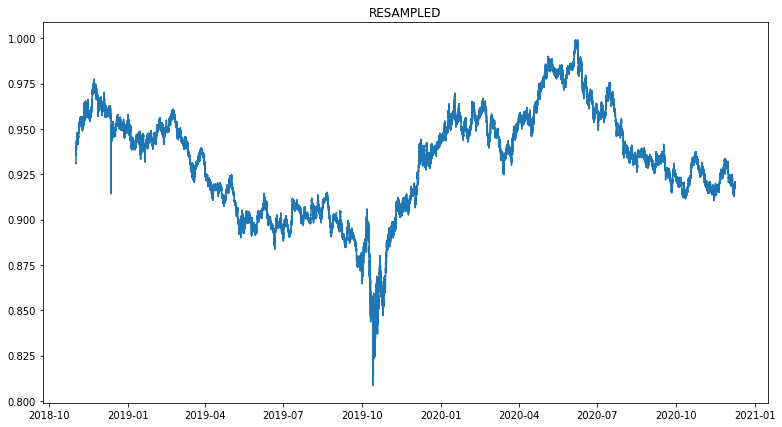

OLD: (745, 6)
NEW: (740, 6)
OPTIMAL_PARAMS:
 {'BuyLossPercent': 0.8333333333333331, 'BuyTakePercent': 0.5888888888888888, 'MaxHold': '603T', 'WindowRoll': '178T', 'Y_STD': 300.0}
INSAMPLE
PNL/DRAWDOWN:-0.5252
    Total trades: 328
    Total pnl -3487.445
    Positive trades: 0.466
    Negative trades: 0.534
    Long trades: 0.509
    Short trades: 0.491
    StopLoss closes: 0.0
    TakeProfit closes: 0.03
    endPeriod closes: 0.97
    
OUTOFSAMPLE
PNL/DRAWDOWN:0.2335
    Total trades: 379
    Total pnl 885.969
    Positive trades: 0.501
    Negative trades: 0.499
    Long trades: 0.517
    Short trades: 0.483
    StopLoss closes: 0.008
    TakeProfit closes: 0.042
    endPeriod closes: 0.95
    


  0%|          | 0/275086 [00:00<?, ?it/s]

  0%|          | 0/306720 [00:00<?, ?it/s]

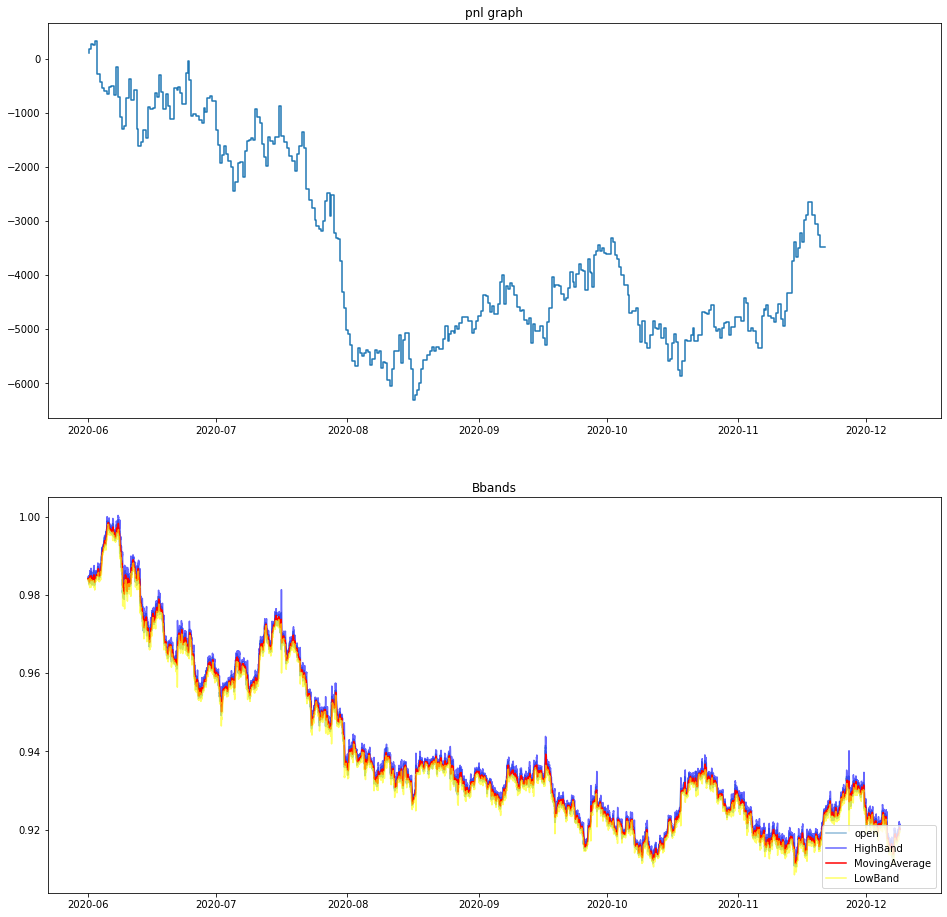

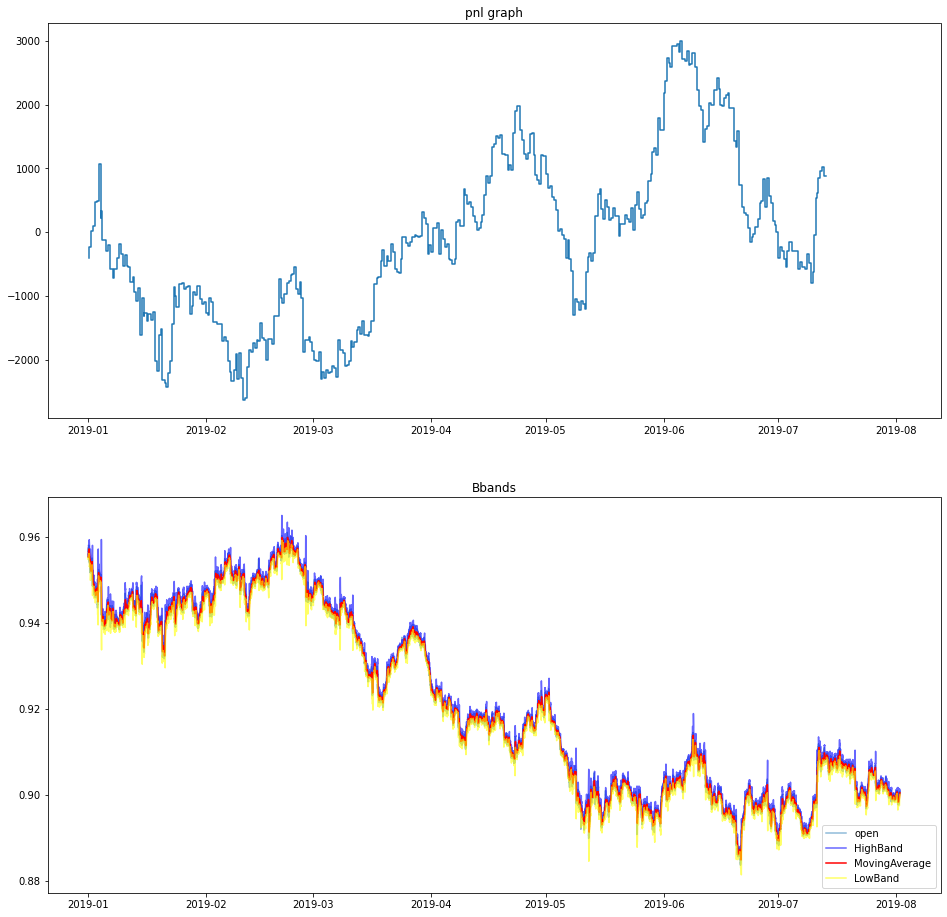

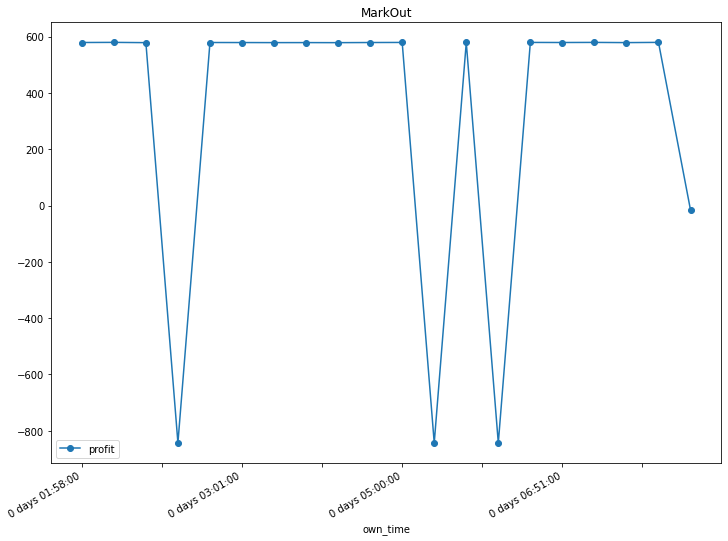

In [7]:
visualise_back('AUDCAD.csv')

In [6]:
def vrRatio(X, ka):
    k = int(pd.Timedelta(ka) / '1T')
    log_prices = np.log(X)
    rets = np.diff(log_prices)
    T = len(rets)

    mu = np.mean(rets)
    sqr_demeaned_x = np.square(rets - mu)
    var_1 = np.sum(sqr_demeaned_x) / (T-1)
    rets_k = (log_prices - np.roll(log_prices,k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    vr = var_k / var_1
    return vr


def only_pnl_visualise_back(file_name):
    PAIR_NAME = file_name.split('.')[0]
    if not os.access('backTEST', os.F_OK):
        os.mkdir('backTEST')

    if not os.access(f'backTEST/{PAIR_NAME}', os.F_OK):
        os.mkdir(f'backTEST/{PAIR_NAME}')

    inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
    # inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
    inp_data.index = pd.to_datetime(inp_data.index)

    """EURGBP columns rename"""
    # inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
    """DATABASE columns drop"""
    inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

    def create_grid(pam_grid_obj):
        CAP = 100_000
        slippage = 10
        BuyLossPercent = pam_grid_obj['BuyLossPercent']
        SellLossPercent = pam_grid_obj['BuyLossPercent']
        BuyTakePercent = pam_grid_obj['BuyTakePercent']
        SellTakePercent = pam_grid_obj['BuyTakePercent']
        MaxHold = pam_grid_obj['MaxHold']
        WindowRoll = pam_grid_obj['WindowRoll']
        Y_STD = pam_grid_obj['Y_STD']

        carrete_hyperParam = pam_grid_obj['caretteHYP']
        # Массив параметров
        PARAMS = {'Capital': CAP,
                  'slippage': slippage,
                  'slippagePerCap': slippage / CAP,
                  'window_rolling': WindowRoll,
                  'Y_threshold': Y_STD,
                  'max_hold_period': MaxHold,
                  'stopLossesPercent':{
                      'BuyLossPercent': BuyLossPercent / 100,
                      'SellLossPercent': SellLossPercent / 100,
                  },
                  'takePercent':{
                      'SellTakePercent': BuyTakePercent / 100,
                      'BuyTakePercent': SellTakePercent / 100,
                  },
                  'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
                  'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency)),
                  'variance_ratio_lookback': pd.Timedelta(WindowRoll) * 2,
                  'variance_ration_carette': (pd.Timedelta(WindowRoll) * 2 / carrete_hyperParam) + pd.Timedelta('1T')
                  }
        del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
        return PARAMS


    def calculate_max_drawdown(PNL_SERIES, dollars=True):
        """
        solution by Marco de Prado
        :param PNL_SERIES:
        :param dollars:
        :return:
        """
        dropout_df = PNL_SERIES.to_frame('pnl')
        dropout_df['hwm'] = dropout_df.expanding().max()
        df0 = dropout_df.groupby('hwm').min().reset_index()
        df0.columns = ['hwm', 'min']
        df0 = df0[df0['hwm'] > df0['min']]
        if dollars:
            dd = df0['hwm'] - df0['min']
        else:
            dd = df0['min'] / df0['hwm']

        return max(dd)

    def _estimator(data_frame, params_dict, show=False):
        DF_lines = []
        save_frame = data_frame.copy()
        # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

        # Скользящее среднее
        data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

        # Скользящее отклонение
        data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

        # Отсечение данных имеющих
        # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

        # Верхний уровень BBand
        data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Нижний уровень BBand
        data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Добавление номера линии для удобства
        data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


        # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
        # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
        ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
        ab = pd.DataFrame(ab)
        # print('AB',len(ab))
        # print('DF',len(data_frame))
        ab.columns = ['value', 'time']
        ab.index = ab.time
        ab = ab.drop(['time'], axis=1)

        correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
        # print('CB',len(correct_borders))
        dot_low_tuple = tuple(data_frame.low)
        dot_high_tuple = tuple(data_frame.high)
        dot_close_tuple = tuple(data_frame.close)
        LowBBand_tuple = tuple(data_frame.LowBBand)
        HighBBand_tuple = tuple(data_frame.HighBBand)
        rolling_mean = tuple(data_frame.rolling_mean)

        cycle_buffer = -10
        ISX = int(pd.Timedelta(params_dict['variance_ratio_lookback']) / '1T') * 3
        if show:
            tqdm_bar = tqdm(total=data_frame.shape[0])

        while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
            openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                         LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                         arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders, opens=dot_close_tuple)

            openLogic['open_time'] = data_frame.index[openLogic['open_index']]
            closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                            dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                            holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0,
                                         rolling_mean=rolling_mean)

            closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
            summary_dict = openLogic | closeLogic
            DF_lines.append(summary_dict)

            cycle_buffer = ISX
            ISX = closeLogic['close_index']
            if show:
                tqdm_bar.update(ISX - tqdm_bar.last_print_n)

        dfResults = pd.DataFrame(DF_lines)
        dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
        dfResults.index = dfResults.close_time
        pnl_series = dfResults["profit"].cumsum()


        optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
        params_dict_opt = params_dict.copy()
        params_dict_opt['result'] = optimizePar
        return [dfResults, data_frame, optimizePar, params_dict_opt]

    def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders, opens):
        """
        Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
        :param current_dot:
        :param arrow_index:
        :return:
        """
        # Задается вид словаря описывающего информацию об открытии сделки
        ret_dict = {'type_operation': None,
                    'position': None,
                    'open_price': None,
                    'open_index': None,
                    'stop_loss_border': None,
                    'take_profit_border': None
                    }
        if arrow_index > len(dot_low_tuple):
            return 'InCorrectData'
        # Проверка о пересечении нижней границы
        if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            if vrRatio(opens[arrow_index-1 - (int(pd.Timedelta(openParams['variance_ratio_lookback']) / '1T')):arrow_index-1], openParams['variance_ration_carette']) < 1.1:
                ret_dict['type_operation'] = 'BUY'
                ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
                ret_dict['open_price'] = LowBBand_tuple[arrow_index]
                ret_dict['open_index'] = arrow_index
                ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
                ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

                return ret_dict
            else:
                return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                    LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                    arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders, opens=opens)

        # Проверка о пересечении верхней границы
        if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            if vrRatio(opens[arrow_index-1 - (int(pd.Timedelta(openParams['variance_ratio_lookback']) / '1T')):arrow_index-1], openParams['variance_ration_carette']) < 1.1:
                ret_dict['type_operation'] = 'SELL'
                ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
                ret_dict['open_price'] = HighBBand_tuple[arrow_index]
                ret_dict['open_index'] = arrow_index

                ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
                ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
                return ret_dict
            else:
                return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders, opens=opens)
        else:
            return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders, opens=opens)


    def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index,
                        time_border_counter, rolling_mean):
        if open_logic['type_operation'] == 'BUY':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index],
                        'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'],
                        'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'],
                        'close_index': arrow_index}
            elif (dot_high_tuple[arrow_index - 1] < rolling_mean[arrow_index - 1]) and (dot_high_tuple[arrow_index] >= rolling_mean[arrow_index]):
                return {'type_holding': 'meanCross', 'close_price': rolling_mean[arrow_index],
                        'close_index': arrow_index}
            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple,
                                       dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1, rolling_mean=rolling_mean)

        if open_logic['type_operation'] == 'SELL':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index],
                        'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'],
                        'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'],
                        'close_index': arrow_index}
            elif (dot_low_tuple[arrow_index - 1] > rolling_mean[arrow_index - 1]) and (dot_low_tuple[arrow_index] <= rolling_mean[arrow_index]):
                return {'type_holding': 'meanCross', 'close_price': rolling_mean[arrow_index],
                        'close_index': arrow_index}

            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple,
                                       dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1, rolling_mean=rolling_mean)


    def plotter(test_df, qqq):
        plt.figure(figsize=(16,16))

        ax1 = plt.subplot(4,1,1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.high, label='high', alpha=.7, color='red')
        plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
        plt.legend(loc='lower right')
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        ax3.set_title('trades histogram')
        for _ in range(test_df.shape[0]):
            if test_df.iloc[_].type_operation == 'BUY':
                plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
            if test_df.iloc[_].type_operation == 'SELL':
                plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
            plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
        ax4 = plt.subplot(4,1,4, sharex=ax1)

        plt.show()

    def lightPlotter(test_df, qqq, final=False, show=False):
        plt.figure(figsize=(16,16))
        if not final:
            plt.title('InSample')
        if final:
            plt.title('OutOfSample')
        ax1 = plt.subplot(2, 1, 1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(2,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
        plt.legend(loc='lower right')
        if not final:
            plt.savefig(f'backTEST/{PAIR_NAME}/bestInSample_{PAIR_NAME}.jpeg')
        if final:
            plt.savefig(f'backTEST/{PAIR_NAME}/outSample_{PAIR_NAME}.jpeg')
        if not show:
            plt.close()

    """WAY TO DELETE HOLIDAYS"""
    inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
    inp_data.index = inp_data.beautiful_time

    plt.figure(figsize=(13,7))
    plt.title('RESAMPLED')
    plt.plot(inp_data.copy().open)
    plt.show()
    # PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
    # PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    # PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    # PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]
    # PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    # optimal = PARAMS_DF.iloc[0]

    PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
    PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss', 'total_pnl', 'variance_ratio_lookback', 'variance_ration_carette']]
    abs_Z_scores = np.abs(zscore(PARAMS_DF.result))
    filtered = (abs_Z_scores < 28)
    print('OLD:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF[filtered]
    PARAMS_DF.reset_index(inplace=True, drop=True)
    print('NEW:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    optimal = PARAMS_DF.iloc[0]
    optimal['caretteHYP'] = int((pd.Timedelta(optimal.window_rolling) * 2)/ (pd.Timedelta(optimal.variance_ration_carette) - pd.Timedelta('1T')))

    print(optimal)
    optParams = {
        "BuyLossPercent": optimal.StopLoss * 100,
        #"SellLossPercent": [20, 30, 40],
        "BuyTakePercent": optimal.TakeProfit * 100,
        #"SellTakePercent": [20, 30, 40],
        "MaxHold": optimal.max_hold_period,
        "WindowRoll": optimal.window_rolling,
        "Y_STD": optimal.Y_threshold,
        'caretteHYP': optimal.caretteHYP
              }



    print('OPTIMAL_PARAMS:\n', optParams)
    # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2018-10-01': '2019-09-15'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    lightPlotter(df, preprocessed_data, show=True)
    print('INSAMPLE')
    print(f"""PNL/DRAWDOWN:{optimizePar}
    Total trades: {df.shape[0]}
    Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    """)

    with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
        file.writelines(f"""
            PNL/DRAWDOWN:{optimizePar}
            Total trades:, {df.shape[0]}
            Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
            Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
            Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
            Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
            Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
            StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
            TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
            endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
            """)

    # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-15'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    lightPlotter(df, preprocessed_data, final=True, show=True)
    print('OUTOFSAMPLE')
    print(f"""PNL/DRAWDOWN:{optimizePar}
    Total trades: {df.shape[0]}
    Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    """)

    with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
        file.writelines(f"""
            PNL/DRAWDOWN:{optimizePar}
            Total trades:, {df.shape[0]}
            Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
            Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
            Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
            Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
            Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
            StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
            TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
            endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
            """)

    df["own_time"] = df.close_time - df.open_time
    plt.figure(figsize=(12,9))
    plt.title('MarkOut')
    ax = plt.subplot(1,1,1)
    df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
    plt.legend(loc='lower left')
    plt.show()

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_6930/1135823001.py:317: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

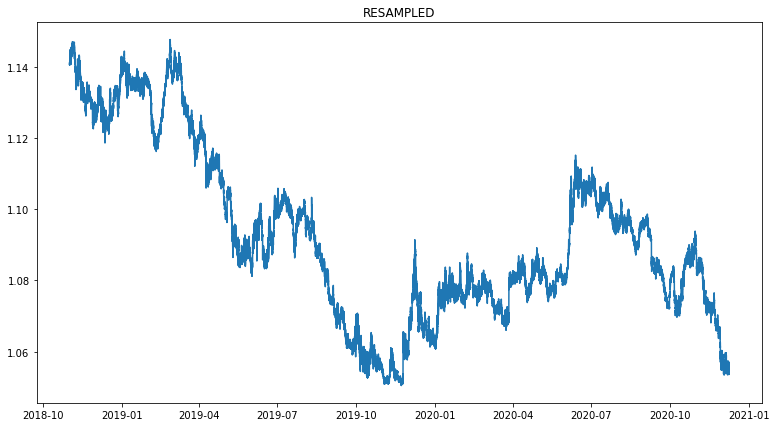

OLD: (290, 9)
NEW: (290, 9)
window_rolling                        950T
Y_threshold                          200.0
max_hold_period                       450T
result                             -0.6391
TakeProfit                        0.022667
StopLoss                          0.007333
total_pnl                     -3863.029255
variance_ratio_lookback    1 days 07:40:00
variance_ration_carette    0 days 03:10:00
caretteHYP                              10
Name: 181, dtype: object
OPTIMAL_PARAMS:
 {'BuyLossPercent': 0.7333333333333334, 'BuyTakePercent': 2.2666666666666666, 'MaxHold': '450T', 'WindowRoll': '950T', 'Y_STD': 200.0, 'caretteHYP': 10}
INSAMPLE
PNL/DRAWDOWN:-0.6389
    Total trades: 687
    Total pnl -3865.564
    Positive trades: 0.684
    Negative trades: 0.316
    Long trades: 0.486
    Short trades: 0.514
    StopLoss closes: 0.003
    TakeProfit closes: 0.0
    endPeriod closes: 0.319
    
OUTOFSAMPLE
PNL/DRAWDOWN:1.0287
    Total trades: 887
    Total pnl 3534.751
    Pos

  0%|          | 0/459525 [00:00<?, ?it/s]

  0%|          | 0/493786 [00:00<?, ?it/s]

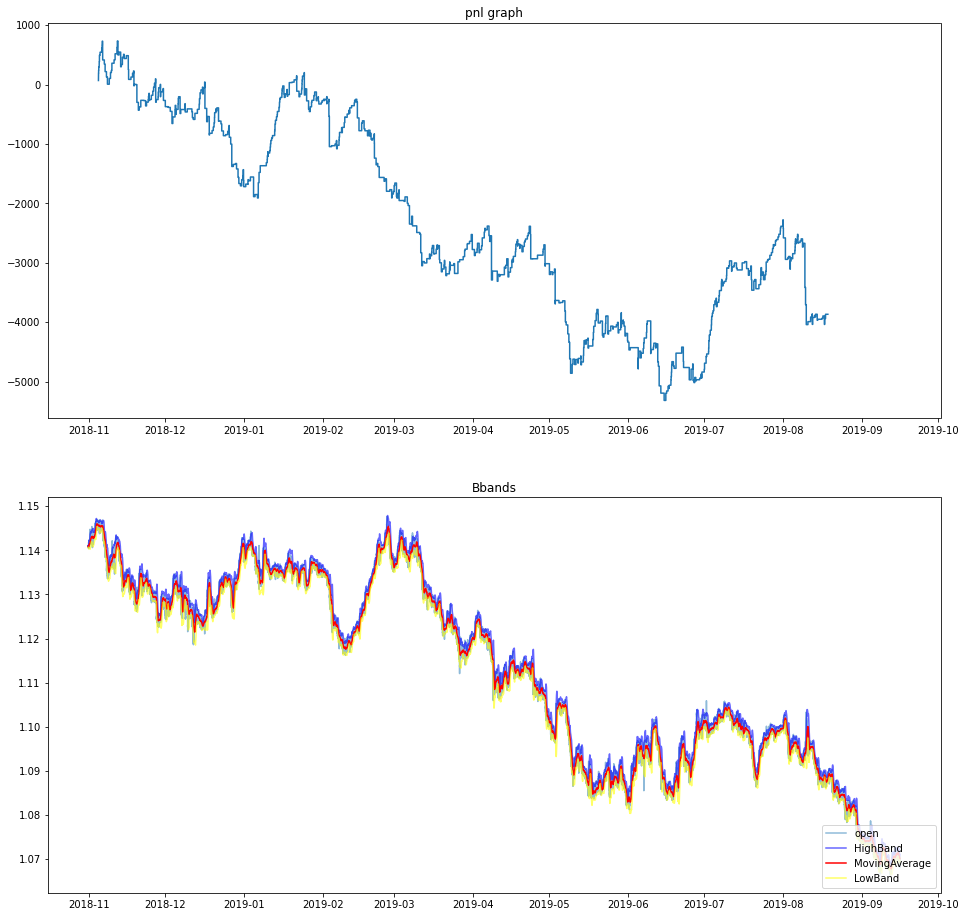

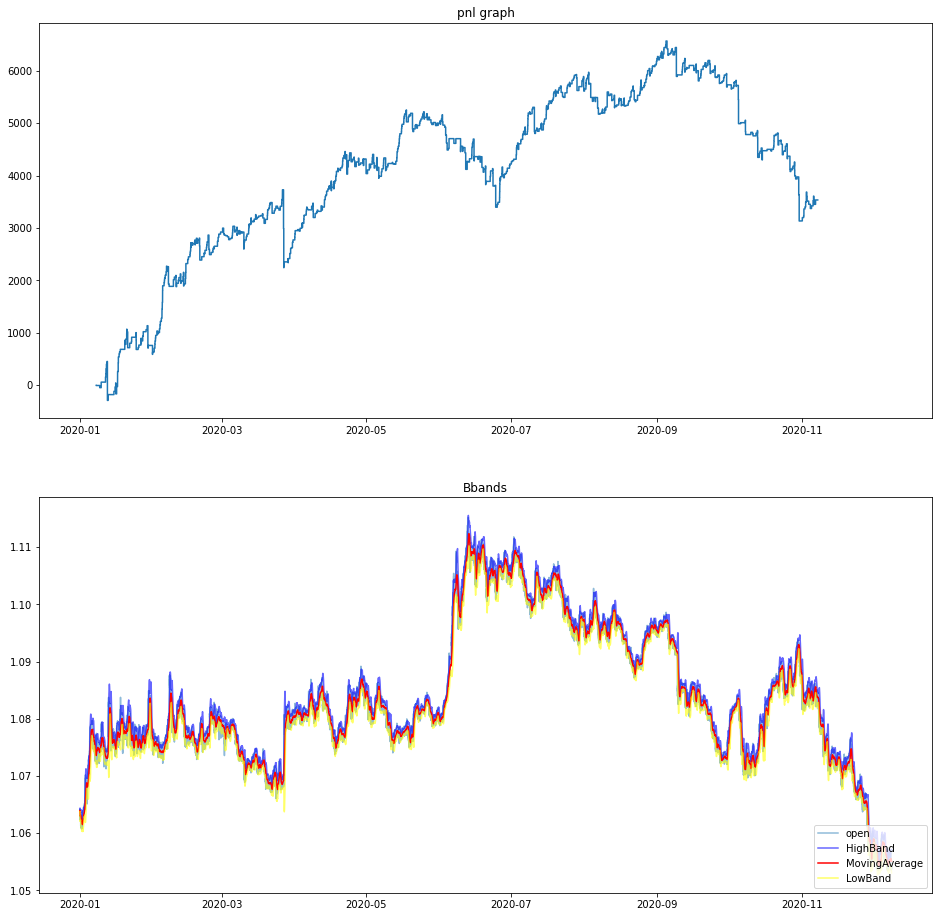

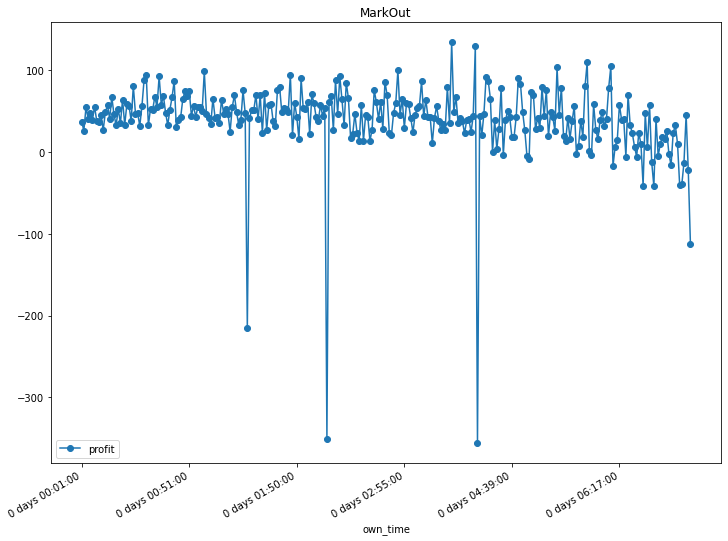

In [10]:
only_pnl_visualise_back('EURCHF.csv')

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_6930/1135823001.py:317: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

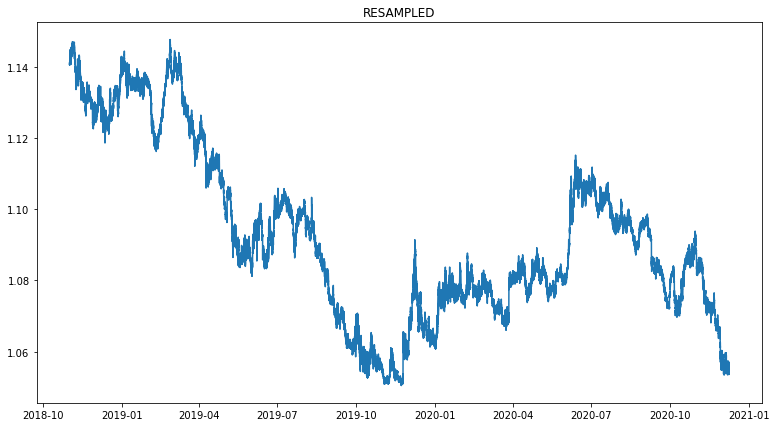

OLD: (290, 9)
NEW: (290, 9)
window_rolling                        950T
Y_threshold                          200.0
max_hold_period                       450T
result                             -0.6391
TakeProfit                        0.022667
StopLoss                          0.007333
total_pnl                     -3863.029255
variance_ratio_lookback    1 days 07:40:00
variance_ration_carette    0 days 03:10:00
caretteHYP                              10
Name: 181, dtype: object
OPTIMAL_PARAMS:
 {'BuyLossPercent': 0.7333333333333334, 'BuyTakePercent': 2.2666666666666666, 'MaxHold': '450T', 'WindowRoll': '950T', 'Y_STD': 200.0, 'caretteHYP': 10}
INSAMPLE
PNL/DRAWDOWN:-0.6389
    Total trades: 687
    Total pnl -3865.564
    Positive trades: 0.684
    Negative trades: 0.316
    Long trades: 0.486
    Short trades: 0.514
    StopLoss closes: 0.003
    TakeProfit closes: 0.0
    endPeriod closes: 0.319
    
OUTOFSAMPLE
PNL/DRAWDOWN:1.0287
    Total trades: 887
    Total pnl 3534.751
    Pos

  0%|          | 0/459525 [00:00<?, ?it/s]

  0%|          | 0/493786 [00:00<?, ?it/s]

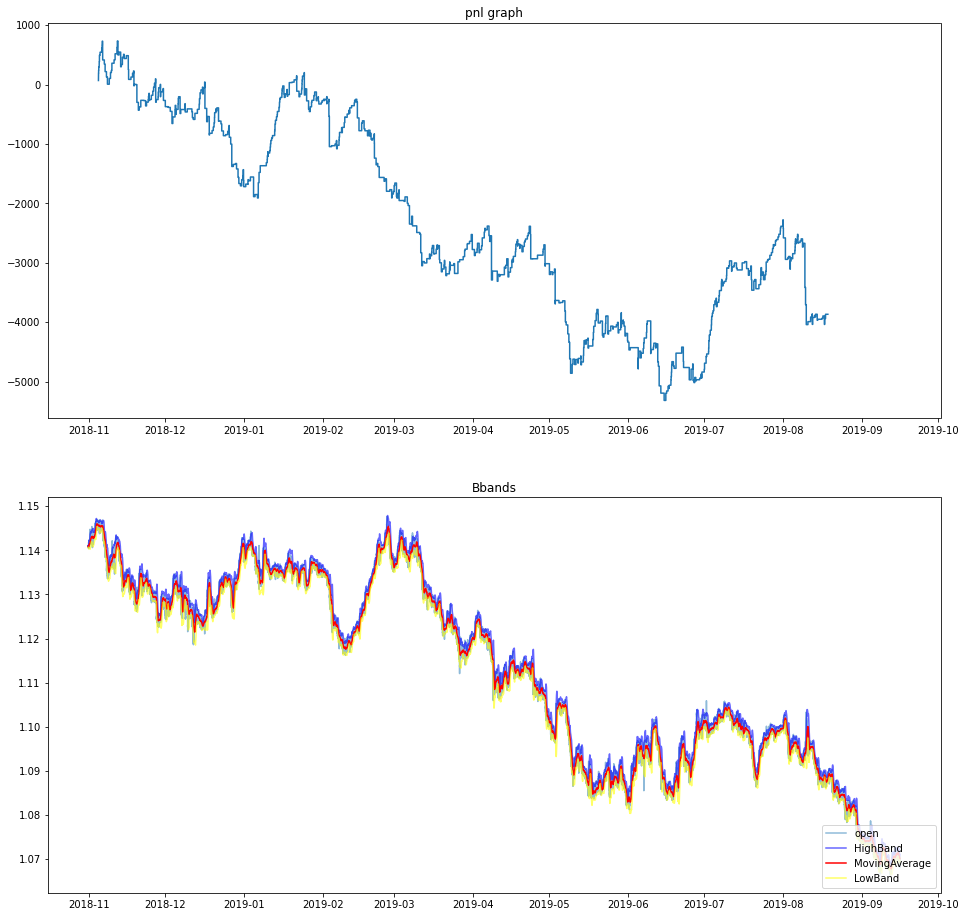

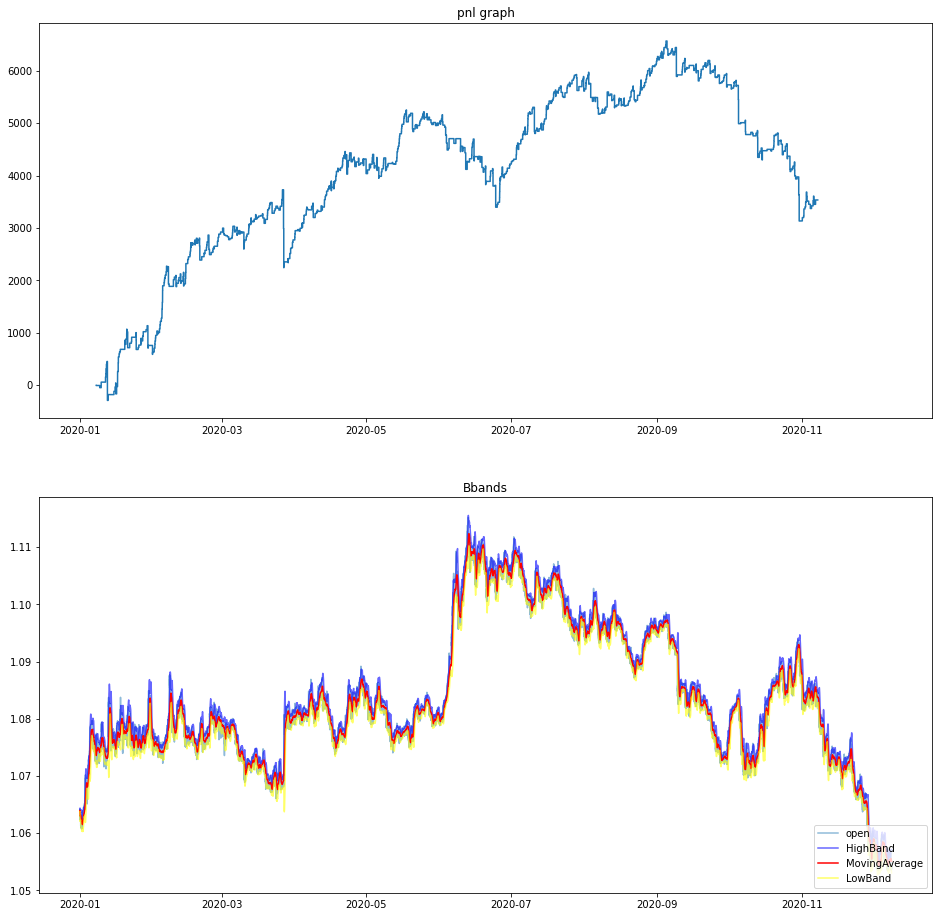

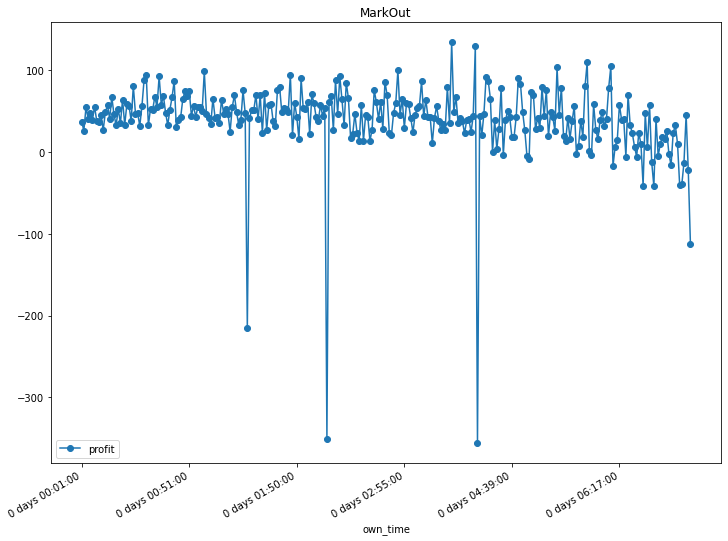

In [12]:
only_pnl_visualise_back('EURCHF.csv')

In [8]:


# inp_data = pd.read_csv('testData/AUDUSD.csv', index_col=1)
# inp_data.index = pd.to_datetime(inp_data.index)
# inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

def _tester(ser):
    return sum(ser)
inp_data = pd.Series([0,0,0,1,2,3,4,5,5, 2, 3, 3,4 , 5, 4,6 ,6 , 1])
inp_data.index = pd.date_range('2020-01-01', end=pd.Timestamp('2020-01-01') + pd.Timedelta(f"{len(inp_data) -1}T"),freq='1T')
# inp_data.rolling('5T').aggregate(lambda x: _estimate(x, '2T'))
inp_data.rolling('5T', min_periods=int(pd.Timedelta('5T') / '1T')).sum()

2020-01-01 00:00:00     NaN
2020-01-01 00:01:00     NaN
2020-01-01 00:02:00     NaN
2020-01-01 00:03:00     NaN
2020-01-01 00:04:00     3.0
2020-01-01 00:05:00     6.0
2020-01-01 00:06:00    10.0
2020-01-01 00:07:00    15.0
2020-01-01 00:08:00    19.0
2020-01-01 00:09:00    19.0
2020-01-01 00:10:00    19.0
2020-01-01 00:11:00    18.0
2020-01-01 00:12:00    17.0
2020-01-01 00:13:00    17.0
2020-01-01 00:14:00    19.0
2020-01-01 00:15:00    22.0
2020-01-01 00:16:00    25.0
2020-01-01 00:17:00    22.0
Freq: T, dtype: float64

In [9]:
inp_data = pd.read_csv('testData/AUDCAD.csv', index_col=1)
inp_data.index = pd.to_datetime(inp_data.index)

"""EURGBP columns rename"""
# inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
"""DATABASE columns drop"""
inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
inp_data.index = inp_data.beautiful_time
inp_data.rolling('5T', min_periods=int(pd.Timedelta('5T') / '1T')).agg(lambda x: _estimate(x, '2T')).iloc[int(pd.Timedelta('5T') / '1T') + int(pd.Timedelta('2T') / '1T'):]


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_6930/2199184501.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')


NameError: name '_estimate' is not defined

In [ ]:
only_pnl_visualise_back('CHFJPY.csv')

In [ ]:
visualise_back('EURGBP.csv')

In [ ]:
visualise_back('AUDCAD.csv')

In [ ]:
visualise_back('CHFJPY.csv')

In [ ]:
PAIR_NAME = 'AUDCAD'
file_name = PAIR_NAME + '.csv'
PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
PARAMS_DF

In [ ]:
visualise_back('EURCHF.csv')

In [ ]:
PAIR_NAME = 'AUDCAD'
file_name = PAIR_NAME + '.csv'
PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]
abs_Z_scores = np.abs(zscore(PARAMS_DF.result))
filtered = (abs_Z_scores < 2)
print('OLD:', PARAMS_DF.shape)
PARAMS_DF = PARAMS_DF[filtered]
PARAMS_DF.reset_index(inplace=True, drop=True)
print('NEW:', PARAMS_DF.shape)
PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
optimal = PARAMS_DF.iloc[0]
print(optimal)

In [ ]:
PAIR_NAME = "AUDUSD"
# Read data and unpack losses and takeProfits
res = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv", index_col=0)
res["TakeProfit"] = res.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
res["StopLoss"] = res.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])

plot = res[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]

# Convert date type to floats
plot.loc[:, 'window_rolling'] = plot.loc[:,'window_rolling'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
plot.loc[:, 'max_hold_period'] = plot.loc[:, 'max_hold_period'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
abs_Z_scores = np.abs(zscore(plot.result))
filtered = (abs_Z_scores < 3)
print('OLD:', plot.shape)
plot = plot[filtered]
plot.reset_index(inplace=True, drop=True)
print('NEW:', plot.shape)

COLUMNS = plot.columns.values
COLUMNS = np.delete(COLUMNS, np.where(COLUMNS == 'result'))

# Scale data to normalize
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaledPlot = pd.DataFrame(scaler.fit_transform(plot.drop('result', axis=1).values))

scaledPlot.columns = COLUMNS
scaledPlot.index = plot.index
scaledPlot
scaledPlot['result'] = plot['result']

In [ ]:
plt.figure(figsize=(17,15))
seaborn.pairplot(data=scaledPlot, x_vars=COLUMNS, y_vars=f"result")

In [ ]:
seaborn.pairplot(data=scaledPlot)

In [ ]:
# Понижаем размерность
pca = PCA(n_components = 2, svd_solver='full')
XPCAreduced = pca.fit_transform(scaledPlot.drop('result', axis=1).values)
# XPCAreduced = pca.fit_transform(scaledPlot.values)
pca.explained_variance_ratio_

In [ ]:
sc = plt.scatter(x=XPCAreduced.T[0], y=XPCAreduced.T[1], c=plot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
dotesOfInterest = [[-3, 2], [-3, 1], [3, 3], [-3, 3], [0, 2], [0, 1]]


dotesOfInterest = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(dotesOfInterest)))
dotesOfInterest.columns = COLUMNS

dotesOfInterest['window_rolling'] = dotesOfInterest['window_rolling'].aggregate(lambda x: str(int(x) // 60) + 'T')
dotesOfInterest['max_hold_period'] = dotesOfInterest['max_hold_period'].aggregate(lambda x: str(int(x) // 60) + 'T')

dotesOfInterest

In [ ]:
pca.explained_variance_ratio_

In [ ]:
"------"
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
scaledTSNE = tsne.fit_transform(scaledPlot.drop('result', axis=1).values)
scaledTSNE.shape

In [ ]:
sc = plt.scatter(x=scaledTSNE.T[0], y=scaledTSNE.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
from sklearn.decomposition import KernelPCA

kernel = KernelPCA(n_components=2, kernel='linear')
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
from sklearn.manifold import MDS

kernel = MDS(n_components=2, max_iter=1_500, verbose=1)
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
# https://www.machinelearningmastery.ru/feature-extraction-techniques-d619b56e31be/

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=20)

X_lle = embedding.fit_transform(scaledPlot.drop('result', axis=1).values)
sc = plt.scatter(x=X_lle.T[0], y=X_lle.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
import umap.umap_


PAIR_NAME = "AUDCAD"
# Read data and unpack losses and takeProfits
res = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv", index_col=0)
res["TakeProfit"] = res.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
res["StopLoss"] = res.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])

plot = res[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]

# Convert date type to floats
plot.loc[:, 'window_rolling'] = plot.loc[:,'window_rolling'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
plot.loc[:, 'max_hold_period'] = plot.loc[:, 'max_hold_period'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
abs_Z_scores = np.abs(zscore(plot.result))
filtered = (abs_Z_scores < 3)
print('OLD:', plot.shape)
plot = plot[filtered]
plot.reset_index(inplace=True, drop=True)
print('NEW:', plot.shape)

COLUMNS = plot.columns.values
COLUMNS = np.delete(COLUMNS, np.where(COLUMNS == 'result'))

# Scale data to normalize
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaledPlot = pd.DataFrame(scaler.fit_transform(plot.values))

scaledPlot.columns = plot.columns
scaledPlot.index = plot.index
scaledPlot

reducer = umap.umap_.UMAP(densmap=True, random_state=42, n_neighbors=100, verbose=True)

In [ ]:
embedding = reducer.fit_transform(scaledPlot)
embedding.shape

In [ ]:
plt.figure(figsize=(12,12))
sc = plt.scatter(x=embedding.T[0], y=embedding.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
pd.DataFrame(reducer.inverse_transform(embedding))

In [ ]:
scaledPlot

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding

kernel = LocallyLinearEmbedding(n_components=2,method='modified', n_neighbors=100)
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
openner = pd.read_csv('testData/AUDUSD.csv', index_col=1).open
openner.index = pd.to_datetime(openner.index)
plt.figure(figsize=(12,7))
plt.title('AUDCAD')
plt.plot(openner)
plt.show()